In [168]:
import numpy as np
import os
import pandas as pd

In [173]:
'''''This script demonstrates how to build a variational autoencoder with Keras. 
 
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114 
'''  
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.stats import norm  
  
from keras.layers import Input, Dense, Lambda  
from keras.models import Model  
from keras import backend as K  
from keras import objectives  
from keras.datasets import mnist  
from keras.utils.vis_utils import plot_model  
import sys

batch_size = 100  
original_dim = 256   
latent_dim = 1
intermediate_dim = 128  #AE is 128
nb_epoch = 50  
epsilon_std = 1.0  
 
#encoding  
x = Input(shape=(original_dim,))  
h = Dense(intermediate_dim, activation='relu')(x)  
z_mean = Dense(latent_dim)(h)  
z_log_var = Dense(latent_dim)(h)  



#Gauss sampling,sample Z  
def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon



z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

 
decoder_h = Dense(intermediate_dim, activation='relu')(z) 
decoder_mean = Dense(original_dim, activation='sigmoid')(decoder_h)




def vae_loss(x, decoder_mean):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoder_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    constrain_loss = -K.sum(K.square(decoder_mean-0.5))
    return xent_loss + 1*kl_loss  + 0*constrain_loss

vae = Model(x, decoder_mean) 
vae.compile(optimizer='rmsprop', loss=vae_loss)  

newdata = pd.read_csv("ISING_simul/IsingModel16_16simul.csv").values
for i in range(len(newdata)):
    for j in range(len(newdata[0])):
        newdata[i][j] = (newdata[i][j]+1)/2
index = [i for i in range(len(newdata))]
import random
random.shuffle(index)
newdata = newdata[index]
x_train = newdata[:15000]
x_test = newdata[15000:20000]





In [174]:
vae.fit(x_train, x_train,  
        shuffle=True,  
        nb_epoch=nb_epoch,  
        #verbose=2,  
        batch_size=100,  
        validation_data=(x_test, x_test))  

/Users/sunhop/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15000 samples, validate on 5000 samples
Epoch 1/50
15000/15000 [==============================] - 1s - loss: 142.3629 - val_loss: 121.3308
Epoch 2/50
15000/15000 [==============================] - 0s - loss: 120.0624 - val_loss: 117.0529
Epoch 3/50
15000/15000 [==============================] - 0s - loss: 117.4710 - val_loss: 114.9279
Epoch 4/50
15000/15000 [==============================] - 0s - loss: 115.6488 - val_loss: 114.0692
Epoch 5/50
15000/15000 [==============================] - 0s - loss: 114.7834 - val_loss: 114.5622
Epoch 6/50
15000/15000 [==============================] - 0s - loss: 114.2989 - val_loss: 112.9004
Epoch 7/50
15000/15000 [==============================] - 0s - loss: 113.7127 - val_loss: 112.8856
Epoch 8/50
15000/15000 [==============================] - 0s - loss: 113.5522 - val_loss: 112.8463
Epoch 9/50
15000/15000 [==============================] - 0s - loss: 113.3552 - val_loss: 112.8489
Epoch 10/50
15000/15000 [==============================] - 0

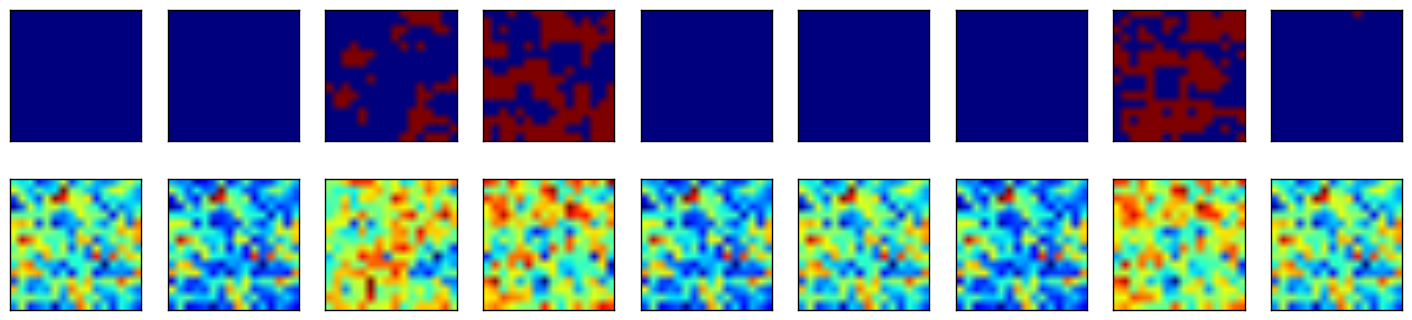

In [175]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
decoded_imgs = vae.predict(x_test,batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow(np.round(x_test[i].reshape(16, 16)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i].reshape(16,16)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

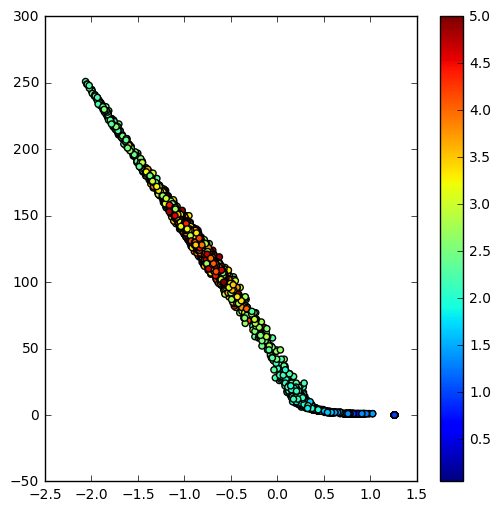

In [176]:
T = np.zeros((20099,))
u=5.025
for i in range(20099):
    
    if i%101==0:
        u = u- 0.025
    T[i]=u
T = T[index]

T_train = T[:15000]
T_test = T[15000:20000]
y_test = np.zeros((len(x_test),))
for i in range(len(x_test)):
    y_test[i]= np.sum(x_test[i])

encoder = Model(x, z_mean)
  
# display a 2D plot of the digit classes in the latent space  
x_test_encoded_1 = encoder.predict(x_test, batch_size=batch_size)  
plt.figure(figsize=(6, 6))  
plt.scatter( (x_test_encoded_1[:, 0]) ,y_test , c=T_test)  
plt.colorbar()  
plt.show()  
  


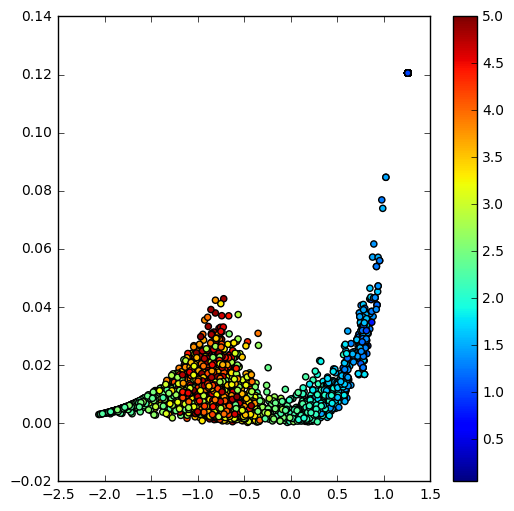

In [177]:
T = np.zeros((20099,))
u=5.025
for i in range(20099):
    
    if i%101==0:
        u = u- 0.025
    T[i]=u
T = T[index]

T_train = T[:15000]
T_test = T[15000:20000]
y_test = np.zeros((len(x_test),))
for i in range(len(x_test)):
    y_test[i]= np.sum(x_test[i])

encoder = Model(x, z_log_var)
  
# display a 2D plot of the digit classes in the latent space  
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)  
plt.figure(figsize=(6, 6))  
plt.scatter( (x_test_encoded_1[:, 0]) ,np.exp(x_test_encoded[:, 0]), c=T_test)  
plt.colorbar()  
plt.show()  
  


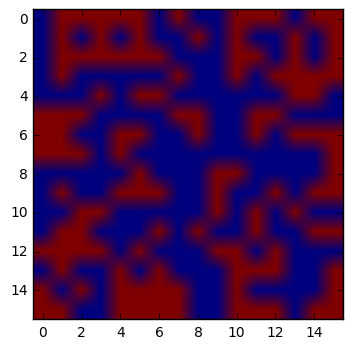

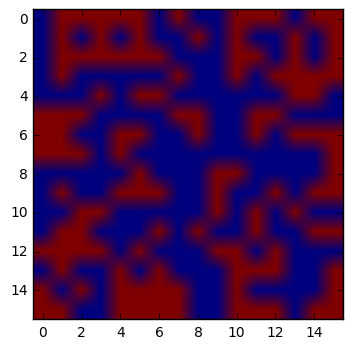

[[0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1]
 [0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1]
 [0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1]
 [0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1]
 [0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0]
 [1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0]
 [1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1]
 [1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1]
 [0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1]
 [0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0]
 [0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1]
 [1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1]
 [1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1]
 [1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1]]
[[ 0.01190379  0.99099851  0.99087685  0.99106532  0.99060678  0.99057591
   0.01223086  0.99140793  0.0117887   0.01116273  0.9901455   0.99078417
   0.99059021  0.01151707  0.9914096   0.99156207]
 [ 0.01236251  0.99114567  0.01081287  0.99140793  0.01144607  0.99086666
   0.01201313  0.01187089  0.99124169  0.01117337  0.98983103  0.01084037
   0.0105748   0.99102741  0.01150125  0.99183637]
 [ 0.01285831  0.9919228   0.9906624   0.

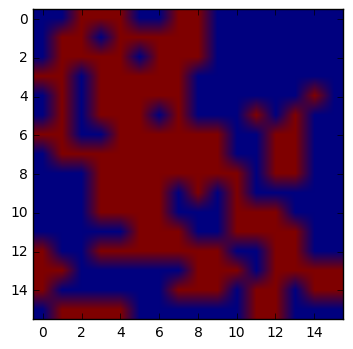

[[0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0]
 [1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0]
 [0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0]
 [1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0]
 [0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0]
 [1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1]
 [1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1]
 [0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0]]


In [114]:
ss = 68
plt.imshow(np.reshape(np.round(decoded_imgs[ss]),[16,16]))
plt.show()
plt.imshow(np.reshape((decoded_imgs[ss]),[16,16]))
plt.show()
print(np.reshape((np.round(decoded_imgs[ss]).astype(int)),[16,16]))
print(np.reshape(((decoded_imgs[ss]).astype(float)),[16,16]))
plt.imshow(x_test[ss].reshape((16,16)))
plt.show()
print(x_test[ss].reshape((16,16)))

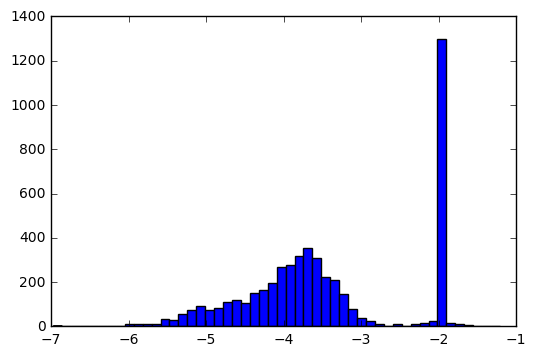

In [117]:
plt.hist(x_test_encoded[:,0],50)
plt.show()